# RecSys for VK contest

Решение Никиты Венедиктова

Необходимо построить векторные представления (эмбеддинги пользователей и фильмов), чтобы рекомендовать фильмы пользователю

1. Разбиение данных на обучение и валидацию
2. Выбор и обоснование метрики
3. Разработка архитектуры сетки
4. Обучение и реализация
5. Воспроизводимость

In [1]:
%pip install pandas matplotlib wordcloud scikit-learn

     ---------------------------------------- 10.7/10.7 MB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 7.6/7.6 MB 7.3 MB/s eta 0:00:00
     -------------------------------------- 152.1/152.1 kB 8.9 MB/s eta 0:00:00
     ---------------------------------------- 8.3/8.3 MB 10.4 MB/s eta 0:00:00
     ------------------------------------- 341.8/341.8 kB 10.4 MB/s eta 0:00:00
     ------------------------------------- 502.3/502.3 kB 10.5 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ---------------------------------------- 55.3/55.3 kB ? eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 9.4 MB/s eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     -------------------------------------- 163.0/163.0 kB 9.5 MB/s eta 0:00:00
     --------------------------------------- 42.5/42.5 MB 10.7 MB/s eta 0:00:00
  Using cached joblib-1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [11]:
movies=pd.read_csv('./ml-latest-small/movies.csv')
ratings=pd.read_csv('./ml-latest-small/ratings.csv')

In [17]:
print(movies.info())
print('\n------------\n')
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [7]:
print(movies.shape,'\n------------\n', ratings.shape)

(9742, 3) (100836, 4)


In [10]:
print(movies.describe(),'\n------------\n', ratings.describe())

             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000 
------------
               userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


Из приведенной выше таблицы можно сделать вывод, что

    Средняя оценка составляет 3,5, а минимальная и максимальная - 0,5 и 5 соответственно.
    Всего 610 пользователей поставили свои оценки 193609 фильмам.

In [18]:
genres=[]
for genre in movies.genres:
    
    x=genre.split('|')
    for i in x:
         if i not in genres:
            genres.append(str(i))
genres=str(genres)    
movie_title=[]
for title in movies.title:
    movie_title.append(title[0:-7])
movie_title=str(movie_title)    

## Data Visualization

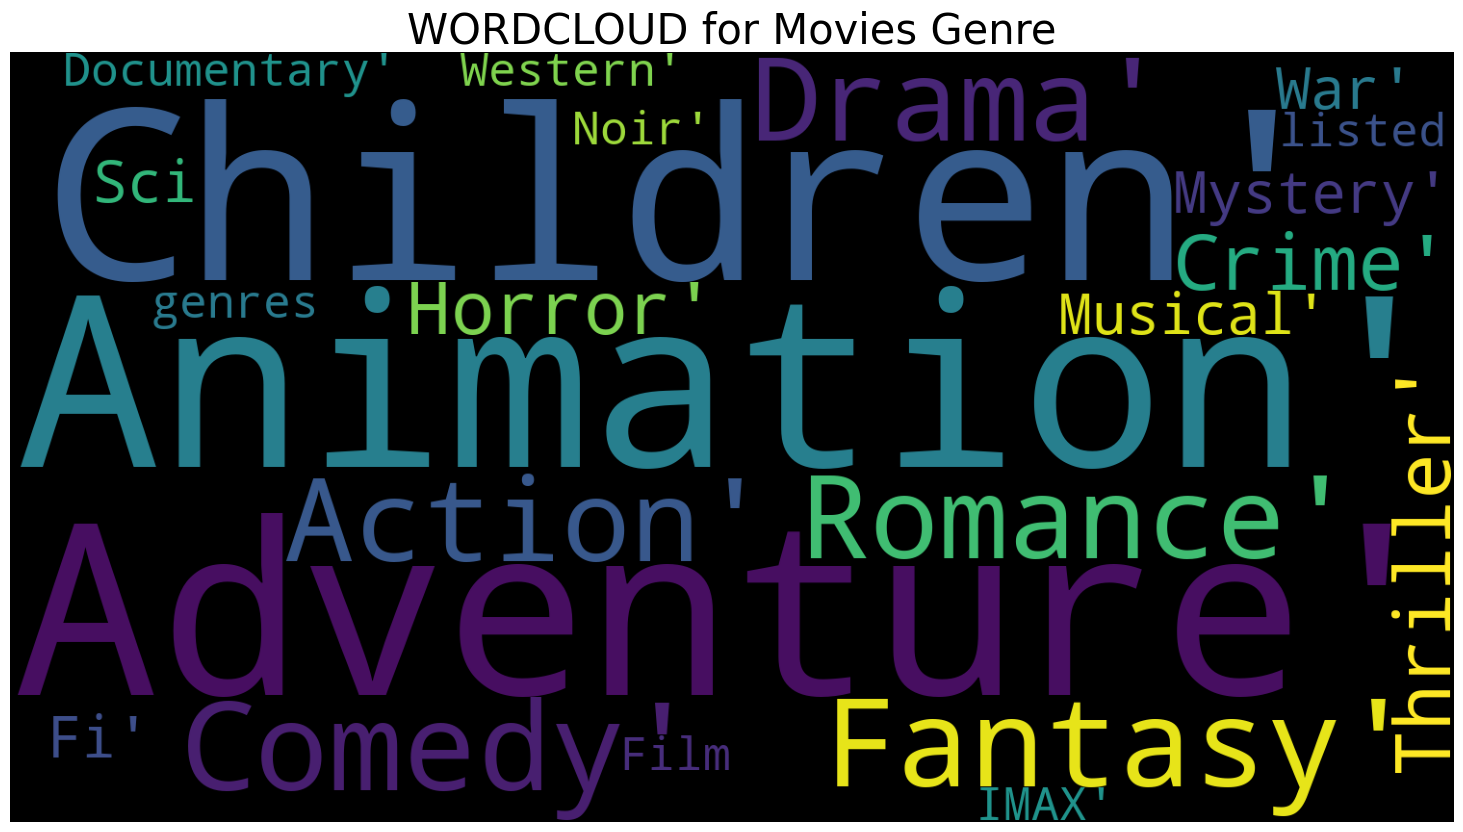

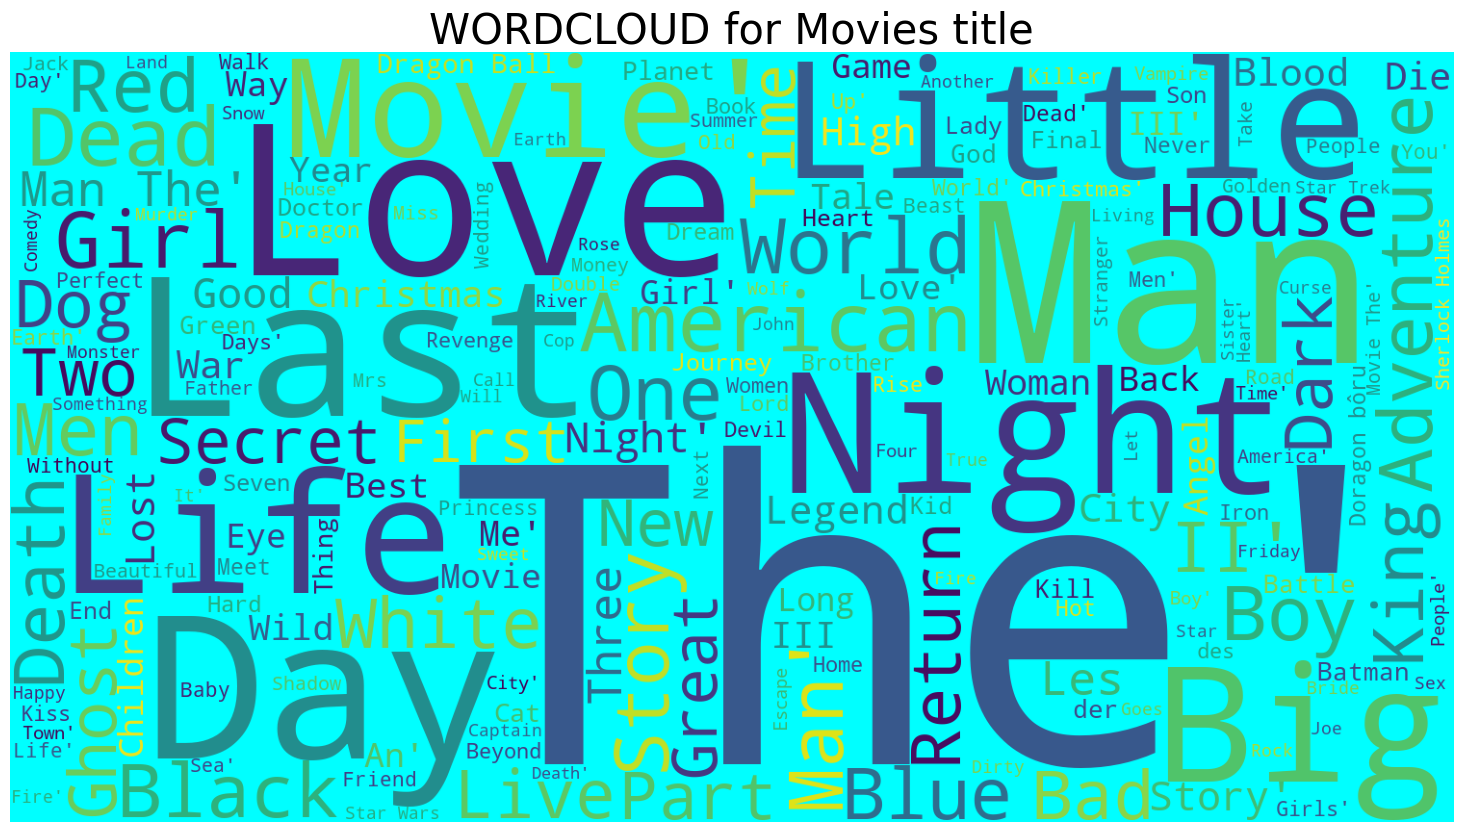

In [20]:
wordcloud_genre=WordCloud(width=1500,height=800,background_color='black',min_font_size=2
                    ,min_word_length=3).generate(genres)
wordcloud_title=WordCloud(width=1500,height=800,background_color='cyan',min_font_size=2
                    ,min_word_length=3).generate(movie_title)

# 
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies Genre',fontsize=30)
plt.imshow(wordcloud_genre)

#
plt.figure(figsize=(30,10))
plt.axis('off')
plt.title('WORDCLOUD for Movies title',fontsize=30)
plt.imshow(wordcloud_title)

In [21]:
df=pd.merge(ratings,movies, how='left',on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [22]:
df1=df.groupby(['title'])[['rating']].sum()
high_rated=df1.nlargest(20,'rating')
high_rated.head()

,rating
title,
"Shawshank Redemption, The (1994)",1404.0
Forrest Gump (1994),1370.0
Pulp Fiction (1994),1288.5
"Matrix, The (1999)",1165.5
"Silence of the Lambs, The (1991)",1161.0


<BarContainer object of 20 artists>

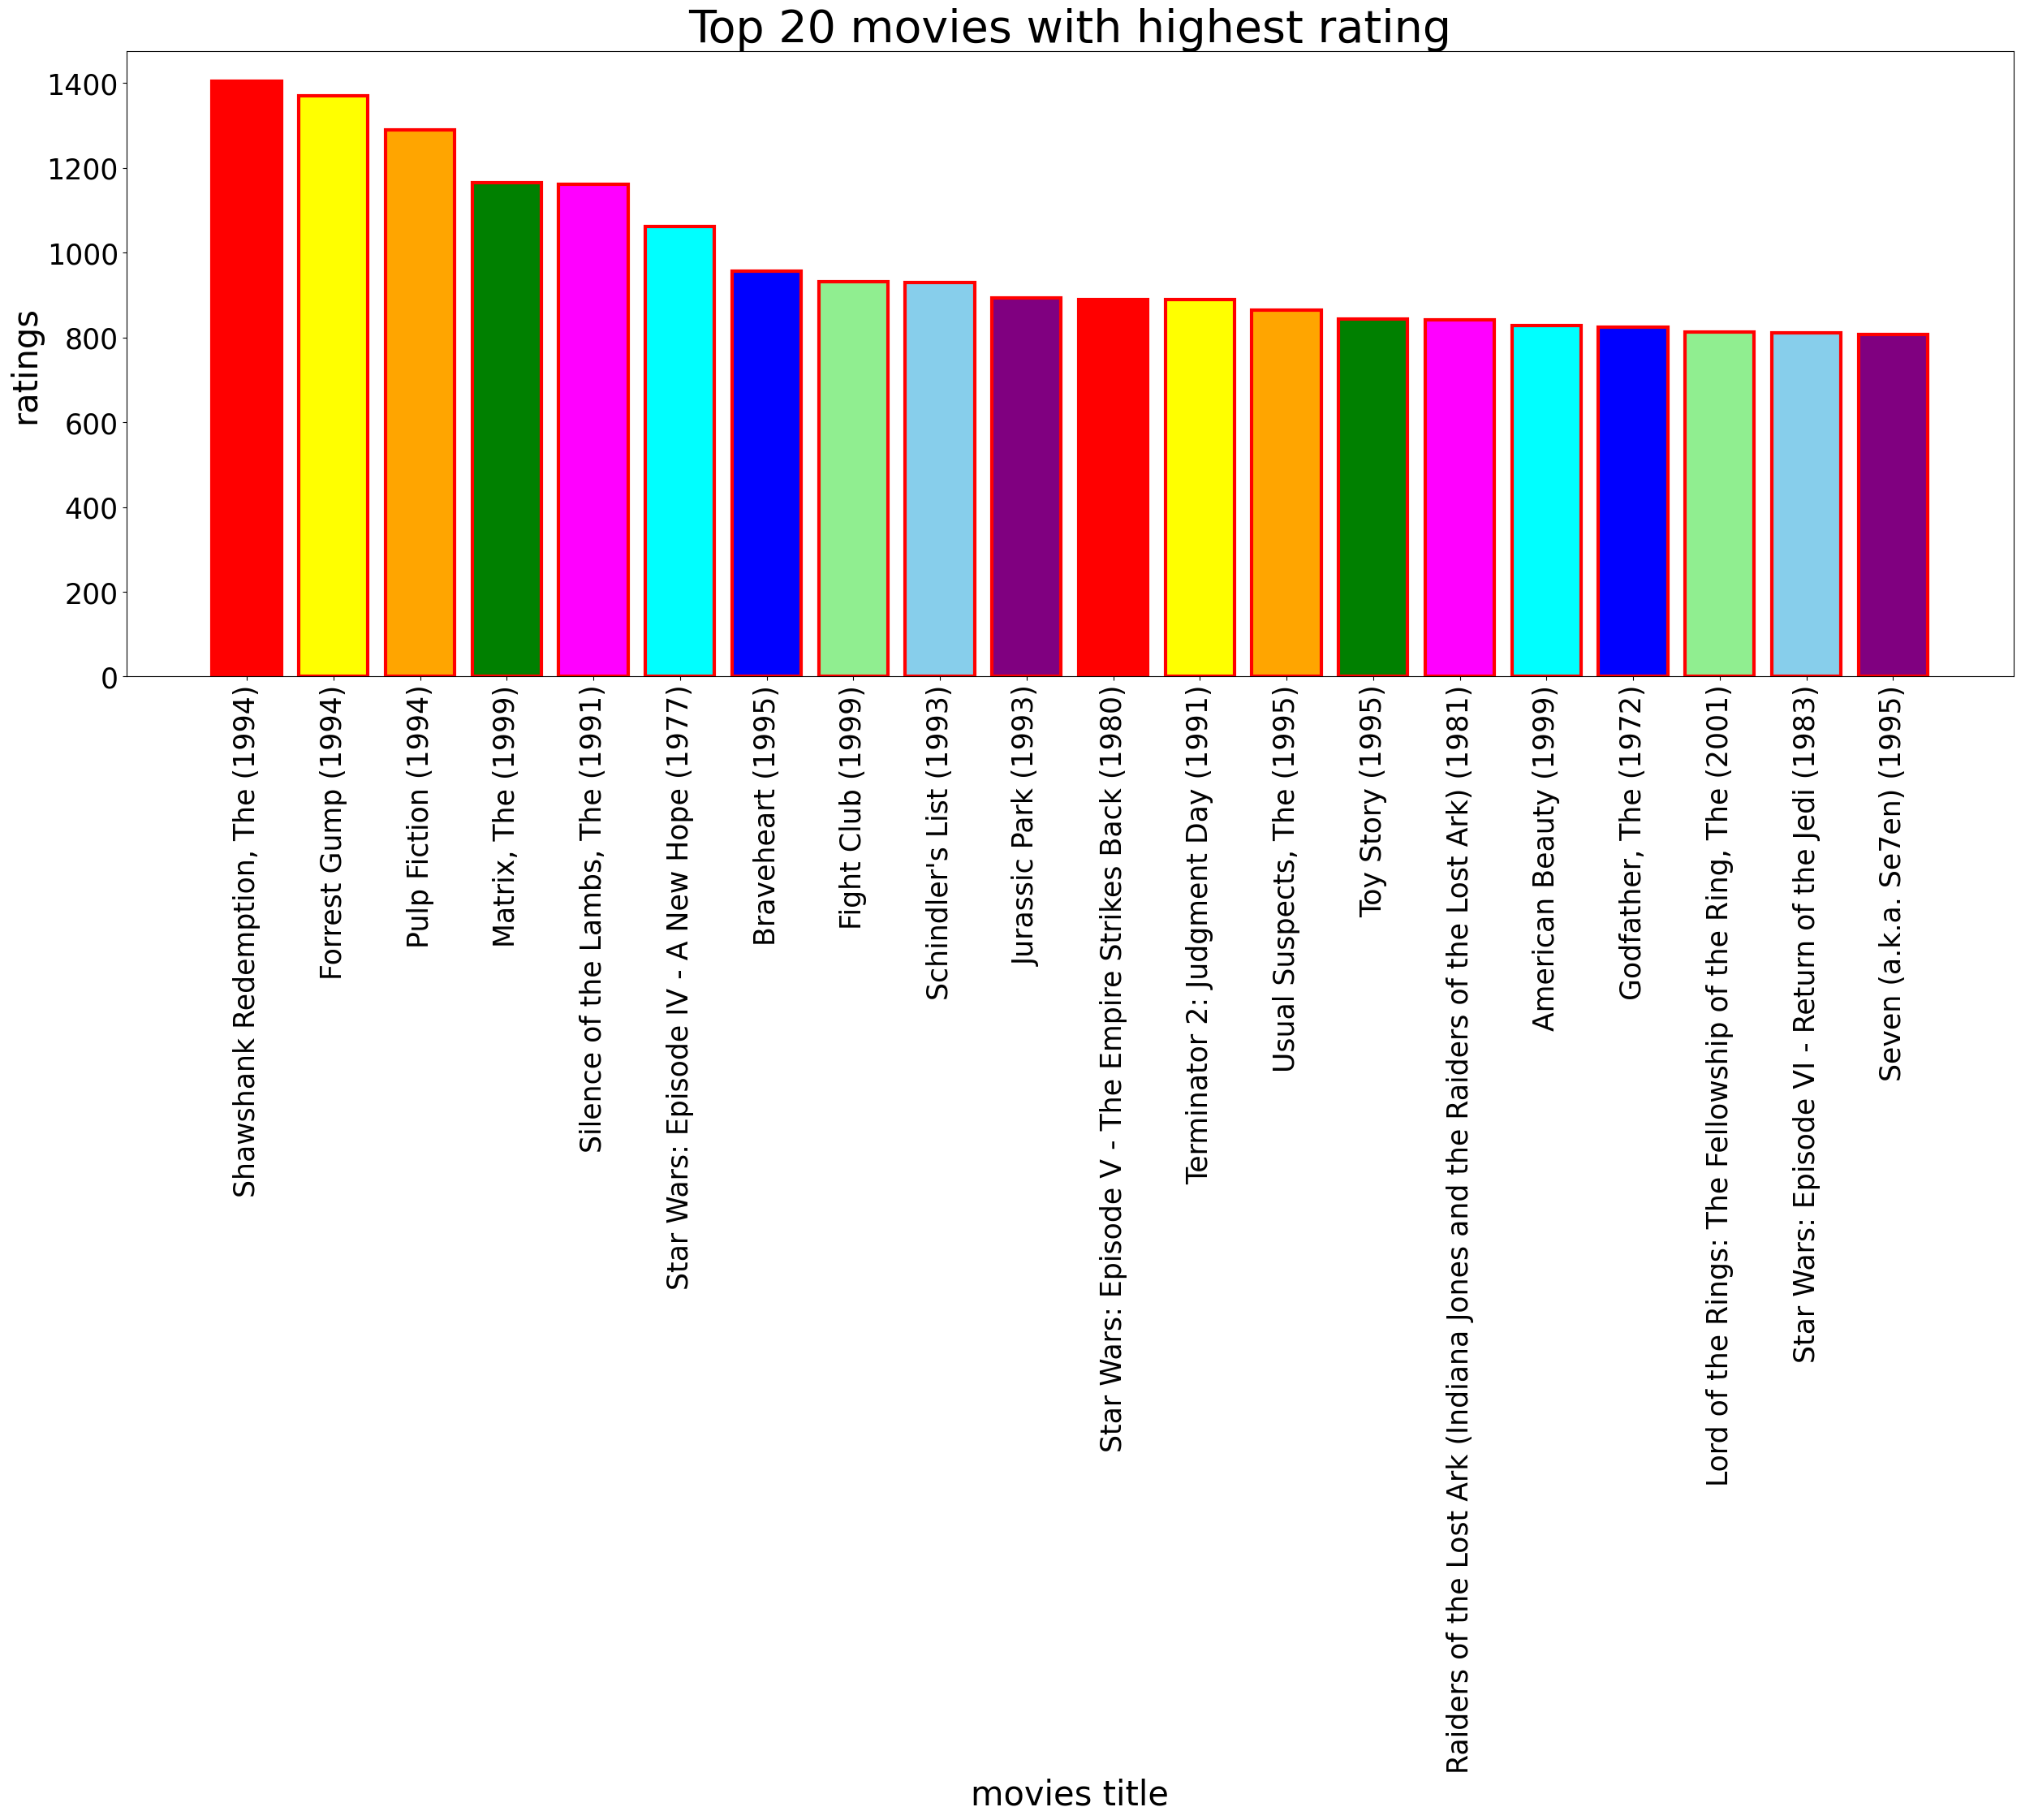

In [23]:
plt.figure(figsize=(30,10))
plt.title('Top 20 movies with highest rating',fontsize=40)
colors=['red','yellow','orange','green','magenta','cyan','blue','lightgreen','skyblue','purple']
plt.ylabel('ratings',fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.xlabel('movies title',fontsize=30)
plt.yticks(fontsize=25)
plt.bar(high_rated.index,high_rated['rating'],linewidth=3,edgecolor='red',color=colors)

In [24]:
df2=df.groupby('title')[['rating']].count()
rating_count_20=df2.nlargest(20,'rating')
rating_count_20.head()

,rating
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278


<BarContainer object of 20 artists>

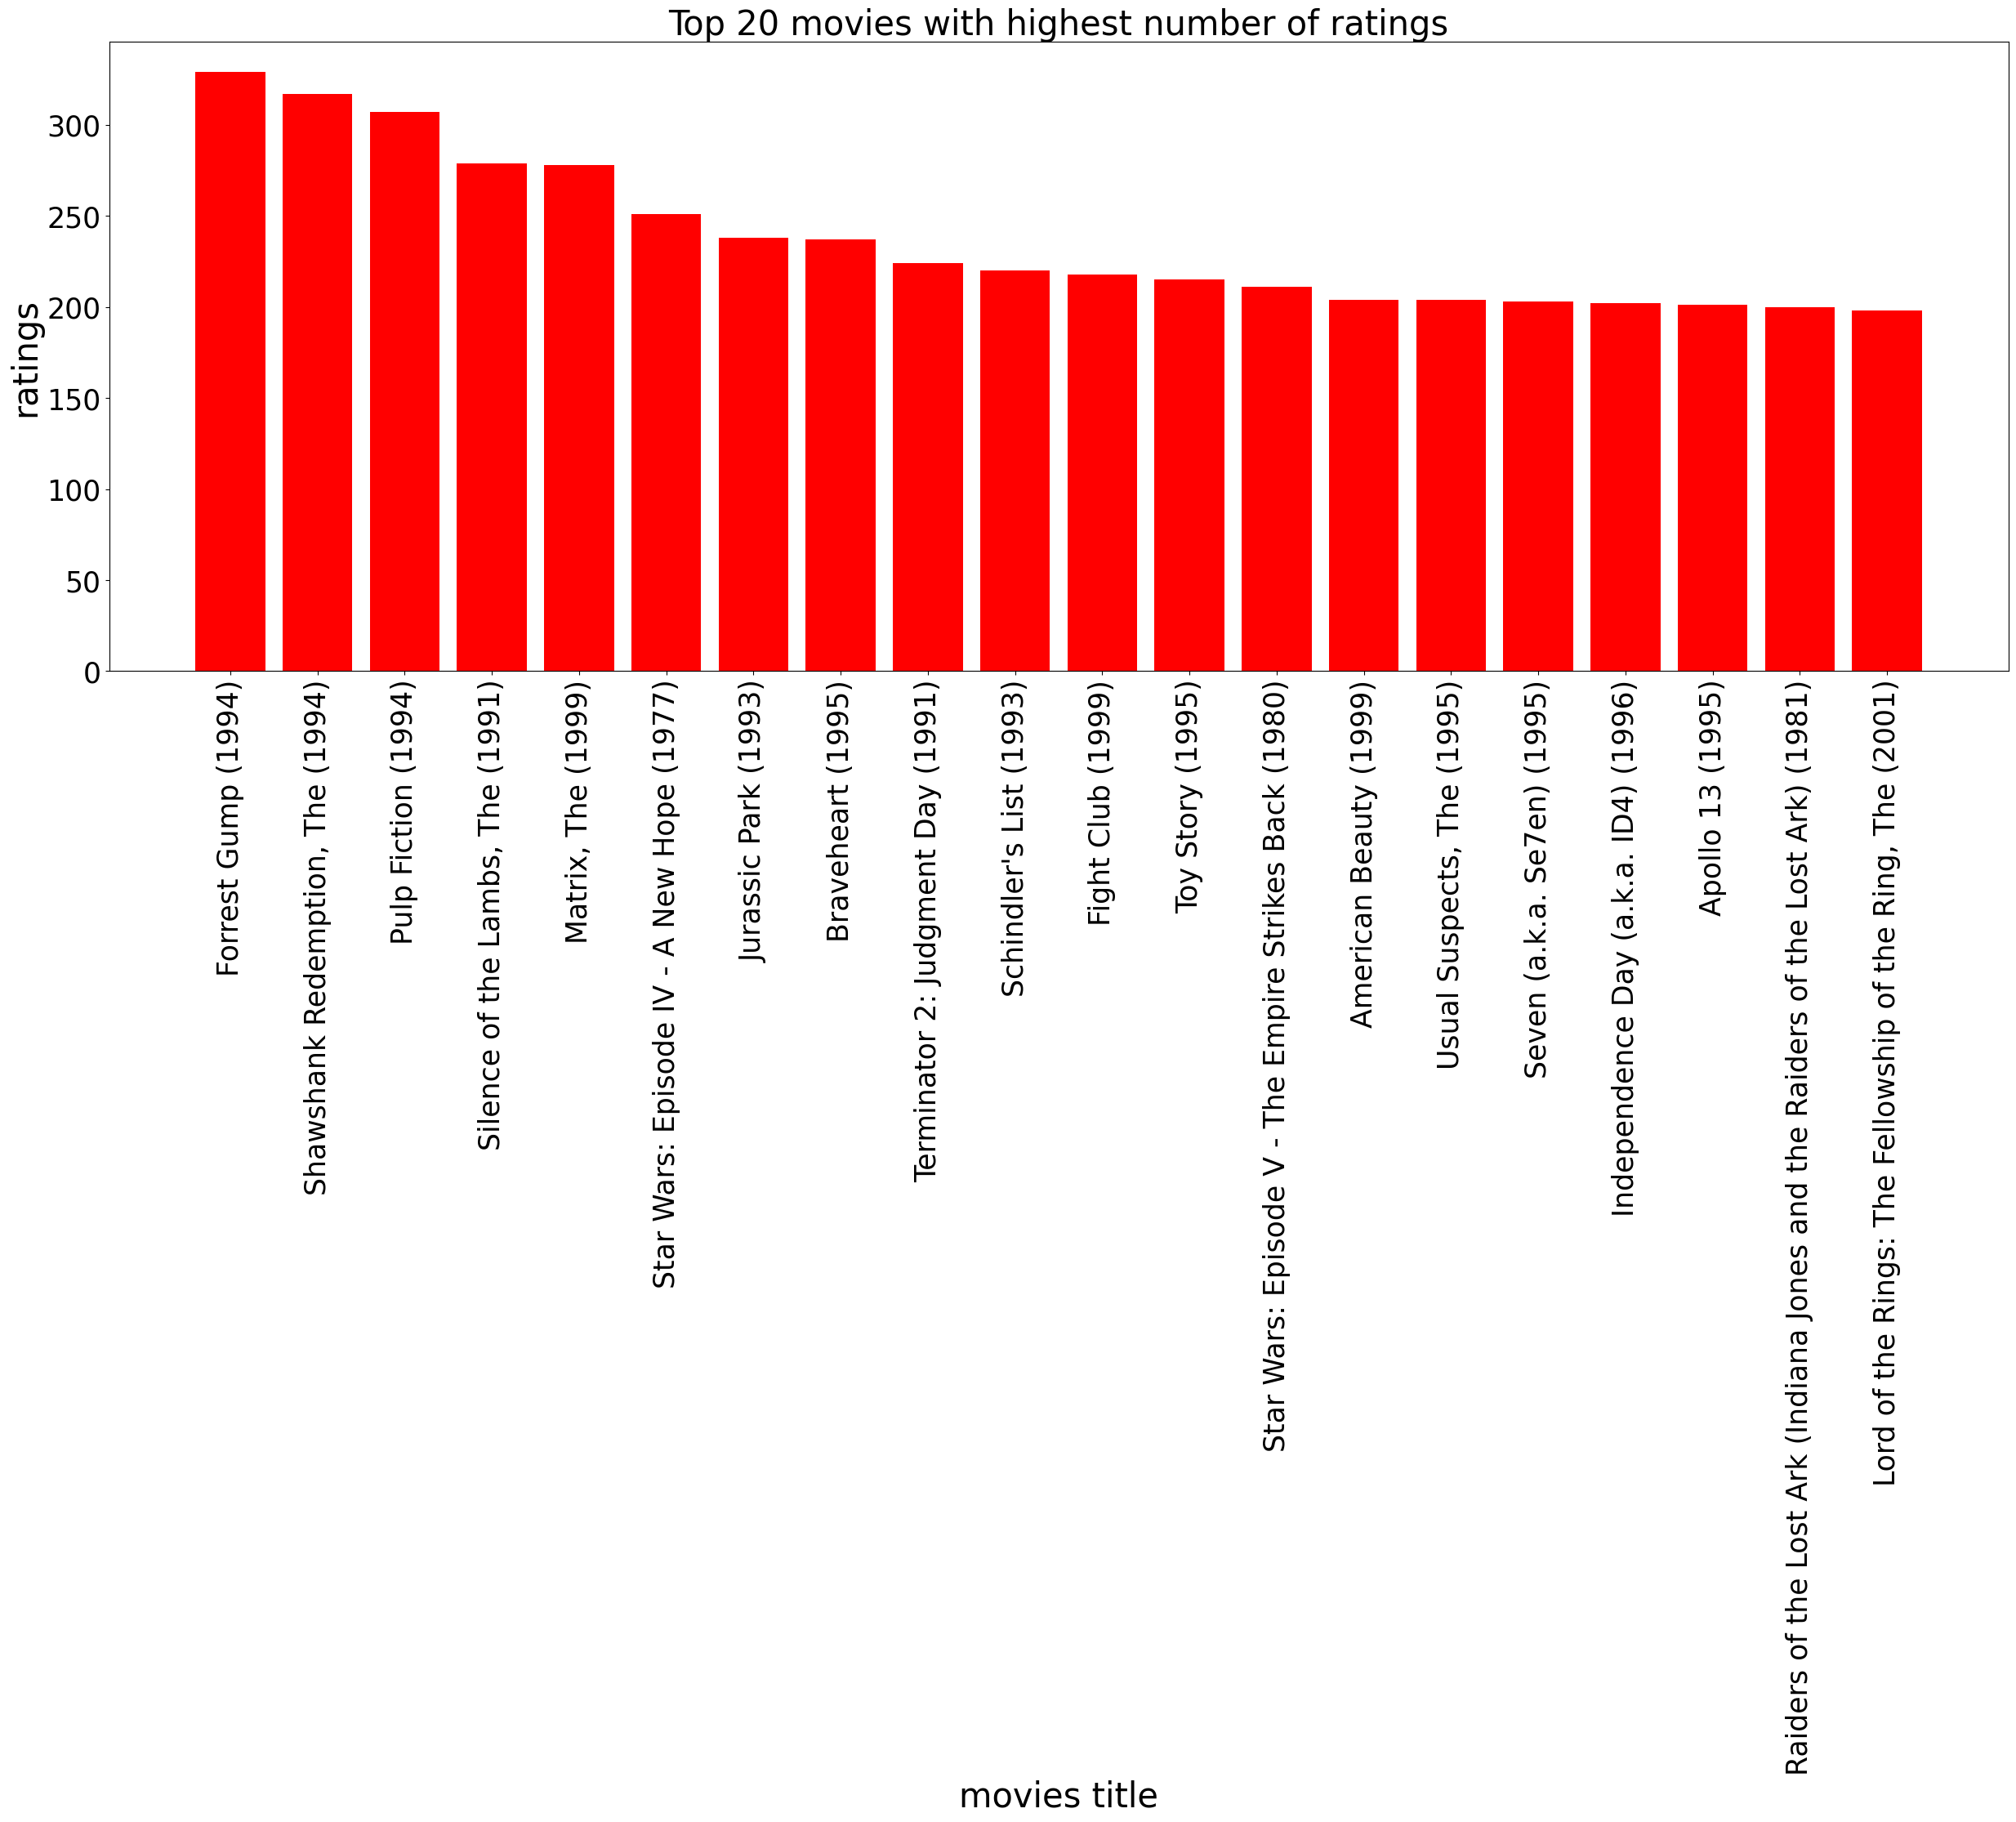

In [25]:
plt.figure(figsize=(30,10))
plt.title('Top 20 movies with highest number of ratings',fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('movies title',fontsize=30)
plt.ylabel('ratings',fontsize=30)

plt.bar(rating_count_20.index,rating_count_20.rating,color='red')

In [26]:
cv=TfidfVectorizer()
tfidf_matrix=cv.fit_transform(movies['genres'])
movie_user = df.pivot_table(index='userId',columns='title',values='rating')
movie_user.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices=pd.Series(movies.index,index=movies['title'])
titles=movies['title']
def recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [33]:
recommendations('Sinbad: Legend of the Seven Seas (2003)')

1577                        Lord of the Rings, The (1978)
2539                We're Back! A Dinosaur's Story (1993)
3230                     Atlantis: The Lost Empire (2001)
3336                         Land Before Time, The (1988)
4014    Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (...
4424              Sinbad: Legend of the Seven Seas (2003)
5087                        Phantom Tollbooth, The (1970)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5686           Cat Returns, The (Neko no ongaeshi) (2002)
6944                   Ponyo (Gake no ue no Ponyo) (2008)
9369                      Kubo and the Two Strings (2016)
9544          Vovka in the Kingdom of Far Far Away (1965)
1596                                Watership Down (1978)
2106        Little Nemo: Adventures in Slumberland (1992)
5546    Kiki's Delivery Service (Majo no takkyûbin) (1...
0                                        Toy Story (1995)
1706                                          Antz (1998)
2355          